In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Importing County, and COVID-19 Data**

**as of (04/16/2020)**

**Note**: see the `data_collection_preprocessing.ipynb` notebook for more info about these datasets. In a nutshell, COVID-19 dataset contains the daily cumulative counts of cases and deaths for US counties (NY Times). The county dataset contains data (county-level) about demographic, health, poverty, and food insecurity factors along with the number of COVID-19 cases and deaths.

In [2]:
counties = pd.read_csv('county_data2.csv', dtype={'FIPS': object})
covid = pd.read_csv('covid_daily.csv', dtype={'FIPS': object})

In [3]:
# remove unwanted strings from food insecurity rate column 'insecure_perc'
counties['insecure_perc'] = counties['insecure_perc'].map(lambda x: x.rstrip('%'))
# convert two columns to be numeric
counties['poverty_per'] = pd.to_numeric(counties.poverty_per, errors='coerce')
counties['insecure_perc'] = pd.to_numeric(counties.insecure_perc)
counties.head()

,County,FIPS,lapop1,lalowi1,laseniors1,lawhite1,lablack1,lahunv1,lapop10,lalowi10,...,WA_FEMALE,BA_MALE,BA_FEMALE,white_per,black_per,nonwhite_per,county,state,cases,deaths
0,Autauga,01001,66.830135,23.638598,7.780032,52.394481,12.177095,1.241818,12.878247,5.306839,...,21801.0,5153.0,5762.0,76.725239,19.630942,23.274761,Autauga,Alabama,27.0,2.0
1,Baldwin,01003,72.229533,24.329145,11.869455,62.858505,5.875821,0.764910,1.598521,0.623267,...,97830.0,9400.0,10092.0,87.285228,8.940382,12.714772,Baldwin,Alabama,114.0,3.0
2,Barbour,01005,69.917552,35.404846,9.323827,36.144285,29.852817,1.548403,20.037873,9.952511,...,5799.0,6370.0,5672.0,49.069571,48.398376,50.930429,Barbour,Alabama,20.0,0.0
3,Bibb,01007,82.558926,39.003412,9.979891,64.481028,16.477732,0.979219,1.290048,0.719630,...,8449.0,2954.0,1816.0,76.834821,21.294643,23.165179,Bibb,Alabama,28.0,0.0
4,Blount,01009,91.138171,35.881851,12.737208,85.069392,0.963189,1.255943,3.411463,1.563625,...,28149.0,507.0,443.0,95.878285,1.642462,4.121715,Blount,Alabama,21.0,0.0


In [4]:
covid.head()

,date,county,state,FIPS,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


## The Big Picture

**The total number of cases and number of new cases over time for the entire country**

In [5]:
# total cases per day
daily_cases = covid.groupby(['date'])['cases'].sum().reset_index()
# total deaths per day
daily_deaths = covid.groupby(['date'])['deaths'].sum().reset_index()
# merging the two dfs
daily_cases = pd.merge(daily_cases, daily_deaths, left_on='date', right_on='date')
# adding daily new cases and deaths columns
daily_cases['new_cases'] = daily_cases['cases'].sub(daily_cases['cases'].shift())
daily_cases['new_deaths'] = daily_cases['deaths'].sub(daily_cases['deaths'].shift())
# adding day numbers
daily_cases['day'] = np.arange(1, len(daily_cases)+1)
# display the last 10 days
daily_cases.tail(10)

,date,cases,deaths,new_cases,new_deaths,day
80,2020-04-10,496906,18719,33217.0,2034.0,81
81,2020-04-11,528414,20578,31508.0,1859.0,82
82,2020-04-12,555330,22057,26916.0,1479.0,83
83,2020-04-13,580894,23608,25564.0,1551.0,84
84,2020-04-14,607263,26081,26369.0,2473.0,85
85,2020-04-15,636877,28585,29614.0,2504.0,86
86,2020-04-16,668543,30786,31666.0,2201.0,87
87,2020-04-17,699860,32885,31317.0,2099.0,88
88,2020-04-18,728047,34723,28187.0,1838.0,89
89,2020-04-19,753319,36108,25272.0,1385.0,90


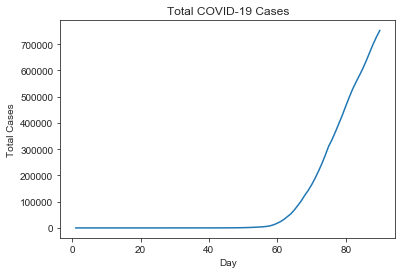

In [6]:
sb.set_style("ticks")
sb.lineplot(data = daily_cases, x = daily_cases['day'], y = daily_cases['cases']);
plt.title('Total COVID-19 Cases');
plt.xlabel('Day');
plt.ylabel('Total Cases');

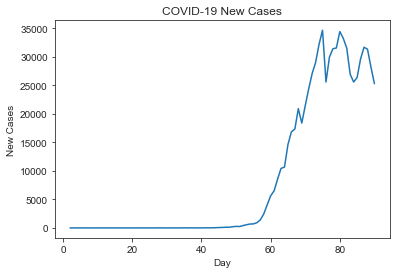

In [7]:
sb.set_style("ticks")
sb.lineplot(data = daily_cases, x = daily_cases['day'], y = daily_cases['new_cases']);
plt.title('COVID-19 New Cases');
plt.xlabel('Day');
plt.ylabel('New Cases');

Looking at the total cases plot alone, it's hard to tell at what stage we are regarding exponential growth in number of cases. The chart for daily new cases may suggest the situation is starting to get under control.

**New Cases vs. Existing Cases**

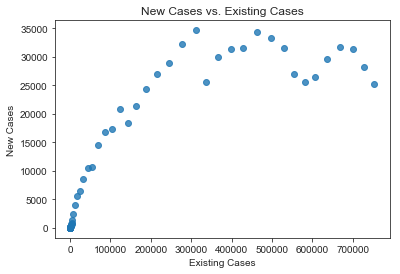

In [8]:
sb.regplot(data = daily_cases, x = daily_cases['cases'], y = daily_cases['new_cases'], fit_reg=False);
plt.title('New Cases vs. Existing Cases');
plt.xlabel('Existing Cases');
plt.ylabel('New Cases');

Another sign that things are getting under control. The number of new cases per day has peaked at the point where total number of cases was approx. 300,000.

## County-level Analysis

**Summary stats for the number of cases and deaths**

In [9]:
# getting summary stats
counties[['cases', 'deaths']].describe()

,cases,deaths
count,2742.000000,2742.000000
mean,272.372721,13.014588
std,2872.067238,194.870319
min,1.000000,0.000000
25%,4.000000,0.000000
50%,16.000000,0.000000
75%,65.000000,2.000000
max,134446.000000,9708.000000


In [10]:
counties[counties['FIPS']=='36061'][['county', 'cases', 'deaths']]

,county,cases,deaths
1858,New York City,134446.0,9708.0


The maximum number of cases for a county is 123,146 (New York County). However, 75% of the counties have 57 cases or fewer. 
The maximum number of deaths for a county is 8,632 (New York County). However, 75% of the counties have 2 deaths or fewer.
It's obvious that NYC has distorted the distribution significantly.

**Summary stats for food access variables**

In [11]:
food_access_vars = ['lapop1', 'lalowi1', 'laseniors1', 'lawhite1', 'lablack1', 'lahunv1', 'lapop10',
                    'lalowi10', 'laseniors10', 'lawhite10', 'lablack10', 'lahunv10']
counties[food_access_vars].describe()

,lapop1,lalowi1,laseniors1,lawhite1,lablack1,lahunv1,lapop10,lalowi10,laseniors10,lawhite10,lablack10,lahunv10
count,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,64.853507,23.979805,10.297337,55.333958,5.005065,1.272281,12.372300,4.792440,2.290314,10.554234,0.577434,0.255553
std,19.741853,11.564173,4.591003,20.084228,9.723430,1.116942,20.960624,8.509418,4.193525,18.569849,2.645282,0.864507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.527736,15.239630,7.332604,42.706424,0.231633,0.656618,0.352949,0.115133,0.051417,0.309913,0.000000,0.002270
50%,66.403185,22.876906,10.020820,56.232913,0.762722,1.057376,3.949291,1.431767,0.643842,3.315507,0.014166,0.049320
75%,78.373358,32.006766,12.789439,69.096864,4.358771,1.586255,14.968922,5.429540,2.601341,12.086237,0.103983,0.218172
max,100.000001,73.418604,29.977290,99.163179,70.732864,19.988265,100.000001,71.844209,29.146426,99.163179,50.136324,19.988265


**Summary stats for food insecurity, poverty, and some demographic variables**

In [12]:
counties[['insecure_perc', 'pop_den_permile', 'poverty_per', 'white_per', 'black_per']].describe()

,insecure_perc,pop_den_permile,poverty_per,white_per,black_per
count,3143.000000,3127.000000,3142.000000,3143.000000,3143.000000
mean,13.251639,256.434890,15.163304,84.458555,9.338106
std,3.959942,1719.713783,6.124835,16.394723,14.472795
min,2.900000,0.000000,2.600000,3.841985,0.000000
25%,10.600000,17.000000,10.800000,79.581916,0.867400
50%,12.800000,45.200000,14.100000,91.392664,2.543449
75%,15.200000,113.500000,18.300000,95.521506,10.855604
max,36.300000,69468.400000,54.000000,99.043785,86.069762


**Variables are (respectively)**: food insecurity rate, population density, % of population below poverty level, % of white population, % of black population.

**Summary stats for some health variables**

In [13]:
counties['old_perc'] = counties['old_perc']*100
counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR']].describe()

,diab_perc,hyper_perc,old_perc,CRUDE_RATE,CRD_MR
count,3127.000000,3127.000000,3127.000000,2935.000000,3127.000000
mean,10.376335,39.407944,13.129517,579.232572,63.816719
std,3.800037,3.654913,3.477859,130.647236,16.881251
min,1.500000,27.900000,3.000000,-1.000000,14.270000
25%,7.800000,37.055000,11.000000,503.000000,52.180000
50%,9.900000,38.770000,13.000000,588.000000,62.400000
75%,12.500000,41.165000,15.000000,658.500000,73.380000
max,33.000000,56.230000,42.000000,1361.000000,160.970000


**Variables are (respectively)**: % of diabetic population, % of population with Hypertension, % of senior people, crude rate for cancer, crude rate for Chronic Respiratory Diseases

## Correlations

**Caveat**: Pearson Correlation Coefficient detects **linear** relationships, while Spearman's Rank Correlation Coefficient could be useful as a measure of **non-linear** relationships.

**COVID-19 metrics with food access features**

**Pearson correlation coefficient**

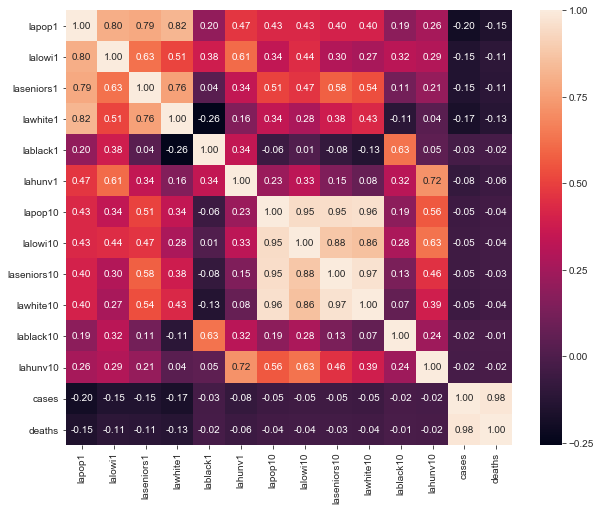

In [14]:
food_access_vars.extend(['cases', 'deaths'])
# correlation matrix
plt.figure(figsize = [10, 8]);
sb.heatmap(counties[food_access_vars].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

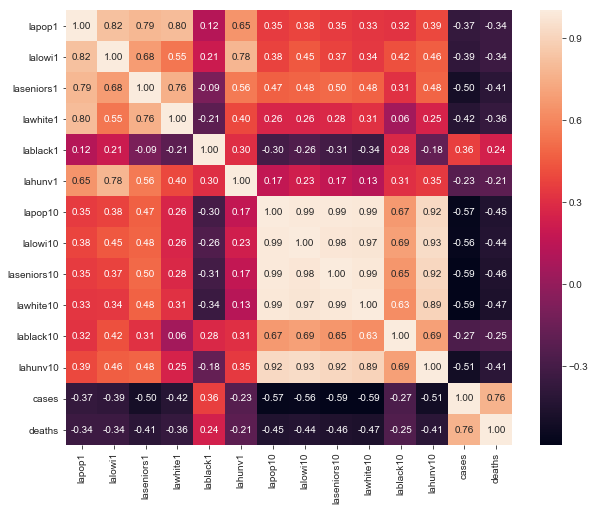

In [15]:
# correlation matrix
plt.figure(figsize = [10, 8]);
sb.heatmap(counties[food_access_vars].corr(method='spearman'), annot=True, fmt='0.2f');

**COVID-19 metrics with demographics**

**Pearson correlation coefficient**

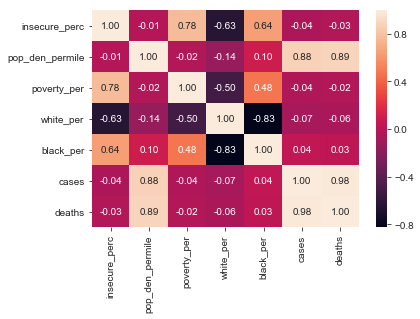

In [16]:
# correlation matrix
sb.heatmap(counties[['insecure_perc', 'pop_den_permile', 'poverty_per',
                     'white_per', 'black_per', 'cases', 'deaths']].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

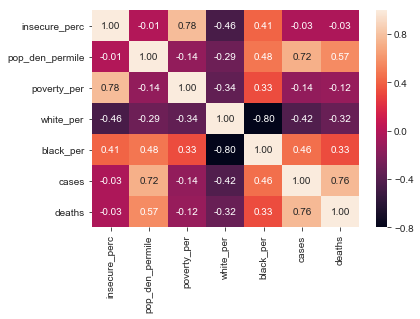

In [17]:
# correlation matrix
sb.heatmap(counties[['insecure_perc', 'pop_den_permile', 'poverty_per',
                     'white_per', 'black_per', 'cases', 'deaths']].corr(method='spearman'), annot=True, fmt='0.2f');

Correlations between black counties and COVID-19 metrics are stronger when using Spearman's coefficient

**COVID-19 metrics with health factors**

**Pearson correlation coefficient**

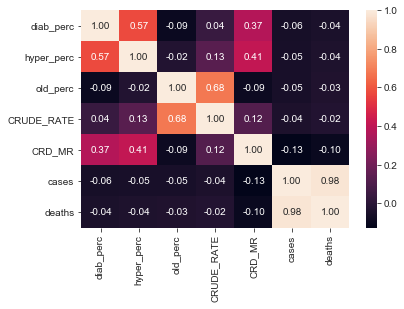

In [18]:
# correlation matrix
sb.heatmap(counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR',
                     'cases', 'deaths']].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

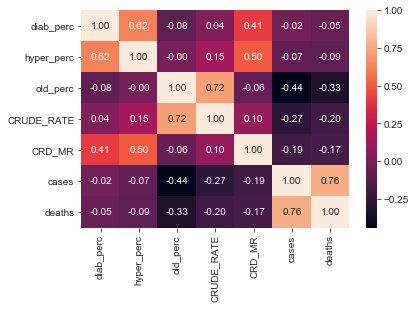

In [19]:
# correlation matrix
sb.heatmap(counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR',
                     'cases', 'deaths']].corr(method='spearman'), annot=True, fmt='0.2f');

## Black Counties
**Excluding New York County**

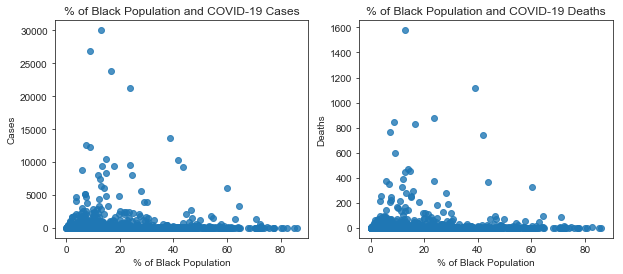

In [20]:
# excluding New York since it's an outlier
exc_ny = counties[counties['FIPS'] != '36061']

plt.figure(figsize = [10, 4]);
#####
plt.subplot(1, 2, 1)
sb.regplot(data = exc_ny, x = exc_ny['black_per'], y = exc_ny['cases'], fit_reg=False);
plt.title('% of Black Population and COVID-19 Cases');
plt.xlabel('% of Black Population');
plt.ylabel('Cases');

plt.subplot(1, 2, 2)
sb.regplot(data = exc_ny, x = exc_ny['black_per'], y = exc_ny['deaths'], fit_reg=False);
plt.title('% of Black Population and COVID-19 Deaths');
plt.xlabel('% of Black Population');
plt.ylabel('Deaths');

More rigorous Hypothesis Testing is needed before any conclusions are made about the relationship between black people and COVID-19 metrics

## Growth of COVID-19 Cases per County

#### Create a Dataframe: rows = counties, columns = dates

The reason this dataframe is created this way is to show the progression of the number of cases per county over time.

In [21]:
# keeping most recent cases and deaths counts
most_recent = covid[covid['date']=='2020-04-16']
# unique county fips
FIPS = list(set(most_recent['FIPS']))
dates = list(set(covid['date']))
dates.sort()

#### Create a zero Dataframe called: `cases`

In [22]:
cases = pd.DataFrame(0, columns=dates, index=FIPS)

#### Populate the `cases` Dataframe from COVID-19 Daily Cases Data

In [23]:
# loop through dates
for date in dates:
    # loop through covid dataframe
    for index, row in covid[covid['date'] == date].iterrows():
        try:
            cases.loc[row['FIPS']][date] = row['cases']
        # if a county doesn't exist in cases df, add it then add its number of cases
        except KeyError:
            cases.loc[row['FIPS']] = 0
            cases.loc[row['FIPS']][date] = row['cases']

# since some counties' FIPS are missing, the 'cases' dataframe
# will have a row labeled 'NaN'. 
# drop the 'NaN' row
cases.drop([np.NaN], axis=0, inplace=True)
cases.head()

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19
06113,0,0,0,0,0,0,0,0,0,0,...,75,88,93,101,102,116,125,126,137,137
27119,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,3
19111,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,2,2,3,3,3,3
18045,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,4,4,5,6
39045,0,0,0,0,0,0,0,0,0,0,...,73,78,81,84,90,92,96,95,97,97


In [24]:
cases_transposed = cases.transpose()

**Plotting cumulative number of cases over the last 30 days for ALL counties**

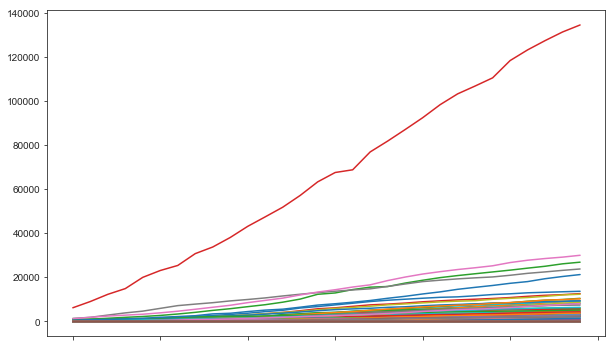

In [25]:
sb.set_style("ticks")
#plt.figure(figsize = [20, 10]);
cases_transposed.iloc[-30:].plot(legend=False);

## Mapping

In [26]:
# path to the county shapefile
path = 'C:\\Users\\Osama\\Desktop\\OneDrive\\Documents\\Research\\Foodbank\\Data\\tl_2018_us_county\\tl_2018_us_county.shp'
# importing the county shape file
map_df = gpd.read_file(path)
# rename the GEOID column to be FIPS
map_df.rename(columns={'GEOID': 'FIPS'}, inplace=True)
# dropping unnecessary columns
map_df.drop(['COUNTYNS', 'NAME', 'LSAD', 'CLASSFP', 'MTFCC',
             'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
             'AWATER', 'INTPTLAT', 'INTPTLON'], axis=1, inplace=True)
map_df.head()

,STATEFP,COUNTYFP,FIPS,NAMELSAD,geometry
0,31,039,31039,Cuming County,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53,069,53069,Wahkiakum County,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35,011,35011,De Baca County,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31,109,31109,Lancaster County,"POLYGON ((-96.91075099999999 40.784944, -96.91..."
4,31,129,31129,Nuckolls County,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


**Combining the shapefile with county data**

In [27]:
# with counties data
merged = pd.merge(map_df, counties, left_on='FIPS', right_on='FIPS')
merged.shape

(3143, 45)

In [28]:
# with cases df, which was derived from the raw NY Times data
merged2 = pd.merge(map_df, cases, left_on='FIPS', right_on=cases.index)
merged2.shape

(2756, 95)

In [29]:
# change map projection
merged['geometry'] = merged['geometry'].to_crs(epsg=3857)
merged2['geometry'] = merged2['geometry'].to_crs(epsg=3857)

**Excluding Alaska and Hawaii for Visualization Purposes**

In [30]:
# removing Hawaii
merged = merged[merged['STATEFP']!='15']
merged2 = merged2[merged2['STATEFP']!='15']
# removing Alaska
merged = merged[merged['STATEFP']!='02']
merged2 = merged2[merged2['STATEFP']!='02']

In [31]:
# keep only the counties with non-null cases
merged = merged[merged['cases'].notnull()]

In [32]:
# color coding will be based on this variable
variable = '2020-04-16'
title = 'COVID-19 Cases in US Counties'
legend_title = 'Number of cases'

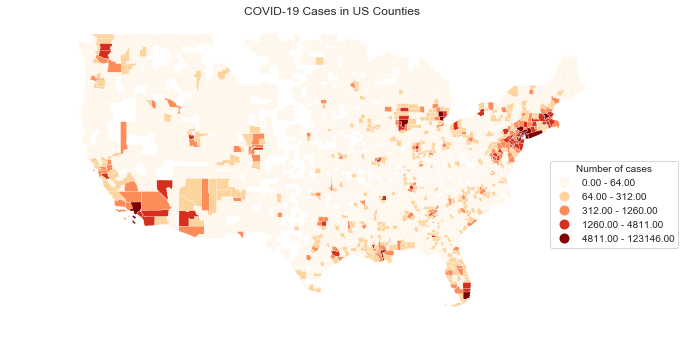

In [33]:
fig, ax = plt.subplots(1, figsize=(10, 10))
merged2.plot(column=variable,cmap='OrRd', scheme='jenks_caspall', legend=True,
            linewidth=0.2, ax=ax, edgecolor='1');

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.93, 0.35, 0.2, 0.2))
leg.set_title(legend_title)
# remove axis
ax.axis('off');
# add a title
ax.set_title(title, fontdict={'fontsize': '12', 'fontweight' : '8'});

In [35]:
fig.savefig('plots/covid_cases_in_US.png', dpi=300);